In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
from engine import Value

In [3]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e*f; L.label = 'L'
L

Value(data=-8.0)

In [4]:
L._prev, L._op

({Value(data=-2.0), Value(data=4.0)}, '*')

Esto nos indica que `d` fue generado a partir de una suma de sus `_children`.

In [5]:
from utils import trace

d_trace = trace(d)
print(f"d_trace nodes: \n\t{d_trace[0]}")
print(f"d_trace edges: \n\t{d_trace[1]}")

d_trace nodes: 
	{Value(data=-6.0), Value(data=-3.0), Value(data=2.0)}
d_trace edges: 
	{(Value(data=-3.0), Value(data=-6.0)), (Value(data=2.0), Value(data=-6.0))}


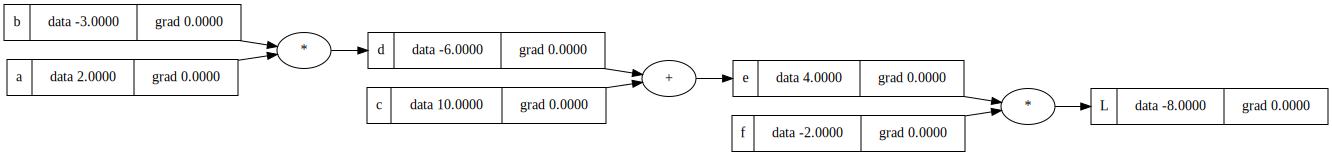

In [6]:
from utils import draw_trace
draw_trace(L)

## **Backpropgation manual**

Empezamos desde el último nodo y vamos a calcular la derivada de este último nodo con respecto a todos los anteriores, que es básicamente lo que se hace en una red neuronal.

In [7]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(-2.0, label='f')
    L = e*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(-2.0, label='f')
    L = e*f; L.label = 'L'
    L2 = L.data

    # Numerical approximation of the derivative of L with respect to a
    print((L2-L1)/h)

lol()

6.000000000021544


La derivada de L con respecto a L es 1.

In [8]:
L.grad = 1.0

Tenemos que $L = e*f$, y queremos saber $\partial{L}/\partial{e}$

Analíticamente, tenemos:
$$
\frac{\partial{L}}{\partial{e}} = f
$$

Y similarmente:
$$
\frac{\partial{L}}{\partial{f}} = e
$$

Entonces:

In [9]:
e.grad = f.data
f.grad = e.data

Ahora queremos obtener la derivada de $L$ con respecto a $c$, es decir $\partial{L}/\partial{c}$.

Veamos primero dónde aparace $c$ en $L$:
$$
\begin{align*}
L &= e * f \\
L &= (d+c) * f
\end{align*}
$$

Entonces, usando la regla de la cadena (muy buenas explicaciones intuitivas en Wikipedia - Chain rule):
$$
\begin{align*}
\frac{\partial{L}}{\partial{c}} &= \frac{\partial{L}}{\partial{e}} \frac{\partial{e}}{\partial{c}}
\end{align*}
$$

Recordemos que ya habíamos calculado $\partial{L}/\partial{e}$ !, era $f$. Entonces, tenemos:
$$
\begin{align*}
\frac{\partial{L}}{\partial{c}} &=
    \frac{\partial{L}}{\partial{e}} \frac{\partial{e}}{\partial{c}} =
    f \frac{\partial{e}}{\partial{c}} =
    f \frac{\partial{(d+c)}}{\partial{c}} =
    f * 1 = f
\end{align*}
$$

Entonces:
- Cuando dos valores se están multiplicando, la derivada de L con respecto a uno de esos
dos, es el otro valor.
- Cuando dos valores se están sumando, la derivada de L con respecto a cada uno es 1. Esto, en la regla de la cadena, provoca que esta operación sea como "nula".

In [10]:
c.grad = f.data

# Para d pasa lo mismo
d.grad = f.data

Ahora el último paso: $\partial{L}/\partial{a}$ y $\partial{L}/\partial{b}$. Tenemos:
$$
\begin{align*}
L &= e * f \\
L &= (d+c) * f \\
L &= ((a*b)+c) * f
\end{align*}
$$

Entonces, la regla de la cadena nos dice:
$$
\frac{\partial{L}}{\partial{a}} =
    \frac{\partial{L}}{\partial{e}} \frac{\partial{e}}{\partial{a}} =
    \frac{\partial{L}}{\partial{e}} \frac{\partial{e}}{\partial{d}} \frac{\partial{d}}{\partial{a}}
$$

Nuevamente, ya calculamos: $\partial{L}/\partial{e}$ y $\partial{e}/\partial{d}$:
$$
\frac{\partial{L}}{\partial{a}} =
    f * 1 * \frac{\partial{d}}{\partial{a}}
$$

Como $d$ es el resultado de una multiplicación, entonces $\partial{d}/\partial{a}$ es simplemente el otro término de la multiplicación, que es $b$, con lo cual llegamos a que:
$$
\frac{\partial{L}}{\partial{a}} = f * b
$$

In [11]:
a.grad = f.data * b.data
b.grad = f.data * a.data

Entonces, si queremos hacer subir el valor de $L$, movemos cada variable dentro de $L$ en la dirección del gradiente:

In [12]:
print(L.data)

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Recalculamos L
d = a * b
e = d + c
L = e * f

print(L.data)

-8.0
-7.286496


## **Backpropagation automático**
Usamos las reglas que acabamos de deducir:
- Regla de la cadena.
- Si los children fueron multiplicados, la derivada "local" de cada término es el otro término.
- Si los children fueron sumados, la derivada "local" de cada término es 1.
